# Orthogonal Decomposition Method with H∞ Controller and Observer Continuous Time

In [538]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from numpy.linalg import pinv, norm,eig,inv
from scipy.integrate import odeint
from scipy.linalg import null_space, orth,inv

In [539]:
# Install MOSEK if not already installed
!pip install mosek

In [540]:
!pip install control

In [541]:
import cvxpy as cp
import control as ct

print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


Function to check observability using Hautus lemma

In [542]:
def pbh_observability_test(A, C):
    lambdas, v = np.linalg.eig(A)
    n = np.shape(A)[0]
    ranks = n*[0]
    test = 'observable'
    for i in range(n):
      A_e = A - lambdas[i]*np.eye(n)
      M = np.vstack((A_e, C))
      ranks[i] = np.linalg.matrix_rank(M)
      if ranks[i] != n:
        test = 'not observable'
    return lambdas, ranks , test



---



# Flat Quadruped

Dynamics with Explicit Constraints: Model
\begin{equation}    
\begin{cases}
& \dot{x} = Ax+Bu+D_1w+F\lambda \\
& G \dot{x}= 0 \\
& y=Cx+D_2w
\end{cases}
\end{equation}


Linear model with implicit constraints:
\begin{equation}    
\begin{cases}
& \dot{z} = A_nz+A_r\zeta +B_n u+D_1w+F\lambda \\
& G \dot{x}= 0 \\
& y=Cx+D_2w
\end{cases}
\end{equation}
where $x=[z,\zeta]^T$

Consider that the desired output is:
\begin{equation}
    z=C_1r+C_2e+D_3w
\end{equation}

Flat Quadruped Linearized Model with Constraints

In [543]:
import scipy.io

J_mat = scipy.io.loadmat('J.mat')
J=J_mat['F']
print("J: ",J)

dJ_mat = scipy.io.loadmat('dJ.mat')
dJ=dJ_mat['dF']
print("dJ: ",dJ)


An_mat = scipy.io.loadmat('An.mat')
An=An_mat['An']
print("An: ",An)

Ar_mat = scipy.io.loadmat('Ar.mat')
Ar=Ar_mat['Ar']
print("Ar: ",Ar)

Bn_mat = scipy.io.loadmat('Bn.mat')
Bn=Bn_mat['Bn']
print("Bn: ",Bn)

J:  [[ 1.00000000e+00  0.00000000e+00 -5.19615243e-01 -5.19615243e-01
   0.00000000e+00 -2.59807621e-01  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00 -5.19615243e-01  0.00000000e+00
  -5.19615243e-01  0.00000000e+00 -2.59807621e-01]
 [ 0.00000000e+00  1.00000000e+00 -5.00000000e-01  7.70628283e-11
   0.00000000e+00  1.49999999e-01  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  7.70194741e-11  0.00000000e+00
   7.70194741e-11  0.00000000e+00  1.49999999e-01]]
dJ:  [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
An:  [[ 1.98278390e+00 -1.43518817e+00 -8.06462857e-01  3.48727190e-01
   2.46671658e-01 -1.45198181e+00]
 [ 3.56623142e+00 -3.35265045e+00 -6.91532096e-01  5.10027628e-01
   1.63666590e+00 -1.25716575e+00]
 [-6.26268636e+00  7.70180539e+00  4.30891861e+00  6.07141500e-02
  -2.58297509e+00  1.22523464e+00]
 [-2.12971548e+00  6.26268069e+00  3.78070419e+00 -1.55585055e+00
   3.97123080e-01 -6.30329463e-01]
 [ 8.23007895e-03  5.42745042e-01 -1.1174536

In [544]:
n=14
dof_z=6
dof_zeta=8

m=4 # dimentions of input
l=10 # dimentions of observer (it works starting from 8)



In [545]:
# C lxn (10,14)
C=np.array([[1,0,0,0,0,0,0,0,1,0,0,0,0,0],
            [0,1,0,0,0,0,0,0,0,1,0,0,0,0],
            [0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            [0,0,0,1,0,0,0,0,0,0,0,1,0,0],
            [0,0,0,0,1,0,0,0,0,0,0,0,1,0],
            [0,0,0,0,0,1,0,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,1,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,1,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,1,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,1,0,0,0,0]])

In [546]:
# D1  nxm (14,4)

D1=0.1*np.array([[1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [0,0,0,0],
            [0,0,0,0]])

# D2  lxm (10,4)

D2=0.01*np.array([[1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [1,0,0,0],
            [0,1,0,0]])



## D3 dof_zxm (6,4)
D3=np.zeros((dof_z,m))

C1=0.1*np.eye(6)

C2=0.1*np.ones((6,14))

C2=0.1*np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,1,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,1,0,0,0,0,0,0,0,0]])


Find  $G$ where:
$$
G=\begin{bmatrix}
J & 0\\
\frac{dJ}{dt} & J
\end{bmatrix}
$$

In [547]:
G=np.vstack((np.hstack((J,np.zeros((4,7)))),np.hstack((dJ,J))))
N=null_space(G) # null space of G
R=orth(G.T) # row space of G

In [548]:
I=np.eye(n)
E=np.hstack((N,R))
# print("E: ",E)
S=np.vstack((np.eye(dof_z),np.zeros((dof_zeta,dof_z))))
N_bar=np.hstack((N,np.zeros((n,dof_zeta))))

In [549]:
D1c=D1
AE=np.vstack((np.hstack((An,Ar)),np.zeros((dof_zeta,n))))
B=Bn
Dn=N_bar.T@D1c


In [550]:
A1=An
A2=AE


In [551]:
K_q=-pinv(B,rcond=10**-9)@Ar

print("K_q:\n",K_q)

Projection=(np.eye(dof_z)-B@pinv(B))@Ar # Projection of Ar into left null space of B
print("Projection of Ar into left null space of B:\n",Projection)

K_q:
 [[-3.49222459e-05 -2.25340697e+01 -2.49081143e-01 -1.01547960e-06
  -7.95071482e+00 -6.37187620e-05 -2.87955373e+01 -2.43809739e-05]
 [-3.81457301e-05 -3.61560366e+01 -8.06109924e-01 -1.64716998e-06
  -1.24497854e+01 -8.27805569e-05 -4.68937246e+01 -2.42621583e-05]
 [ 1.01227050e-05 -2.99833191e+01 -7.31156323e-01 -1.12797125e-06
  -1.13016678e+01 -1.95861821e-05 -3.91190701e+01  1.85230368e-05]
 [ 1.65696734e-05 -2.73938561e+00  3.82901236e-01  1.35409507e-07
  -2.30352670e+00  1.85374073e-05 -2.92269587e+00  1.82854056e-05]]
Projection of Ar into left null space of B:
 [[-4.06731361e-12 -2.05292888e-08  2.15847065e-08 -5.76752938e-13
  -3.30652792e-08 -8.49920227e-12  9.72103152e-09  1.82224472e-12]
 [-1.43055884e-11 -3.23774568e-07 -7.36114326e-08 -2.37126338e-11
  -3.48833730e-08 -1.62550490e-11 -5.29589153e-07 -2.94666850e-12]
 [ 1.47242270e-11  2.15526045e-06  6.35306326e-08 -2.83474980e-12
   3.30562484e-07  1.97928746e-11  2.77299921e-06  1.45718578e-11]
 [-7.05764603e-12

In [552]:
lambdas, ranks , test=pbh_observability_test(A2, C@E)

print(test)

observable


In [553]:
# initial condition
x_real_0 =np.random.randn(n,) # Set initial state
x_hat_0 = x_real_0+0.1*np.random.randn(n,) # Set initial state estimation

print("x_real_0:\n",x_real_0)
print("x_hat_0:\n",x_hat_0)

x_real_0:
 [-0.39189683  1.97250337 -0.23582935  0.76007977  0.6053623   0.1900159
 -0.53307869  0.34503103 -0.31394061  1.55520888  1.88854985  1.78557975
 -0.09180024 -0.03645896]
x_hat_0:
 [-0.4171852   1.97576735 -0.22216603  0.82051103  0.65884586  0.11832009
 -0.43028439  0.35551895 -0.32260356  1.6399944   1.96300071  1.77513821
 -0.03656857 -0.02869358]


In [554]:
# x_real_0:
#  [ 1.19080019  0.19211986  0.85648873  1.73717901 -0.58417362 -0.72838893
#   0.17467838  1.25455565  1.76030815 -0.64254584 -1.15545777  1.87850946
#   0.46571256 -0.81823538]
# x_hat_0:
#  [ 1.37393953  0.40664292  0.78377984  1.63291058 -0.60514955 -0.77845606
#   0.17063325  1.21209075  1.78496018 -0.62523815 -1.07773849  2.00206923
#   0.38713554 -0.82919539]



---



# LMI

In [555]:


I=np.eye(n)

P1 = cp.Variable((dof_z,dof_z),symmetric=True)
Q2 = cp.Variable((n,n),symmetric=True)

U = cp.Variable((m,dof_z))
V = cp.Variable((n,l))



obj = cp.Minimize(0)
constraints = []

Psi1=P1@A1.T+A1@P1+B@U+U.T@B.T
Psi2=A2.T@Q2+Q2@A2-V@C@E-E.T@C.T@V.T



H=cp.vstack((cp.hstack((P1,np.zeros((dof_z,dof_zeta)))),cp.hstack((np.zeros((dof_zeta,dof_z)),np.eye(dof_zeta)))))


Term1=cp.hstack((B@U,B@K_q))

epsilon=0.06

LMI= cp.bmat([[Psi1,np.zeros((dof_z,n)),Term1,np.zeros((dof_z,n))],
            [np.zeros((n,dof_z)),Psi2,np.zeros((n,n)),np.eye(n)],
             [Term1.T,np.zeros((n,n)),-(1/epsilon)*H,np.zeros((n,n))],
             [np.zeros((n,dof_z)),np.eye(n),np.zeros((n,n)),-epsilon*H]])




constraints.extend([P1>>0])
constraints.extend([Q2>>0])
constraints.extend([LMI<<0])




prob = cp.Problem(obj, constraints)

result = prob.solve(solver=cp.MOSEK,verbose=True)

e_p, _ = np.linalg.eig(P1.value)
e_q, _ = np.linalg.eig(Q2.value)





K_r=U.value@pinv(P1.value)
L=pinv(Q2.value)@V.value

print("K_r: ",K_r)
print("L: ",L)



                                     CVXPY                                     
                                     v1.3.3                                    
(CVXPY) Feb 14 11:45:17 AM: Your problem has 396 variables, 3 constraints, and 0 parameters.
(CVXPY) Feb 14 11:45:17 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 14 11:45:17 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 14 11:45:17 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 14 11:45:17 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 14 11:45:17 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

In [556]:
## Check closed loop stability
K=np.hstack((K_r,K_q))
A_close=np.vstack((np.hstack((A1+B@K_r,-B@K)),np.hstack((np.zeros((14,6)),A2-L@C@E))))

e, _ = np.linalg.eig(A_close)
print("eigenvalues of the closed loop system: ",e)

print("max eigenvalue: ",max(e.real))

eigenvalues of the closed loop system:  [-8.60955349 +0.j         -4.52309364 +0.j
 -2.32658045 +0.j         -1.15645808 +0.j
 -0.58221567 +0.j         -0.80031963 +0.j
 -0.94068917+13.63186488j -0.94068917-13.63186488j
 -0.96437857 +7.15330548j -0.96437857 -7.15330548j
 -1.01771857 +3.92811885j -1.01771857 -3.92811885j
 -0.79475561 +1.39667433j -0.79475561 -1.39667433j
 -0.78495362 +0.48921944j -0.78495362 -0.48921944j
 -0.84063248 +0.44815674j -0.84063248 -0.44815674j
 -0.71551032 +0.j         -0.83645664 +0.j        ]
max eigenvalue:  -0.5822156749111556


### Simulate LMI without input distrbance

In [557]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import place_poles
from matplotlib.pyplot import *
from scipy.integrate import odeint

def sys_ode(state, t):

    x= state[0:n]
    r=x[0:dof_z]
    q=x[dof_z:]
    x_hat=state[n:]


    A_o=np.vstack((np.hstack((An,Ar)),np.zeros((dof_zeta,n))))

    B_o=np.vstack((B,np.zeros((dof_zeta,m))))

    u=K@x_hat

    y_hat=C@E@x_hat

    y=C@E@x


    dx_hat=A_o@x_hat+B_o@u+L@(y-y_hat)


    e=x-x_hat

    dr=An@r+B@K_r@r-B@K@e

    dx = np.hstack((dr, [0,0,0,0,0,0,0,0]))

    dstate = np.hstack((dx, dx_hat))
    return dstate


In [558]:
T = 30# Final time

t = np.linspace(0, T, int(2E5)) # Create time span

# x_real_0 = [0.2,0.1,0.1,0,0,1] # Set initial state
# x_hat_0 =  [0.21,0.11,0,0,0,1.2]

state_0 = np.hstack((x_real_0, x_hat_0))

state_sol = odeint(sys_ode, state_0, t)

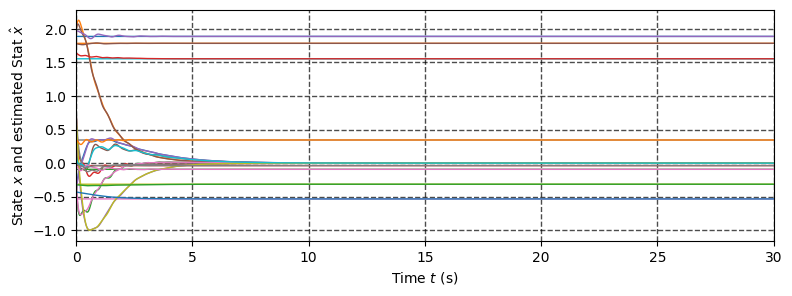

In [559]:
figure(figsize=(9, 3))

plot(t, state_sol, linewidth=1.0)
# plot(t, state_sol[:,n], linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'State ${x}$ and estimated Stat $\hat{x}$')
xlabel(r'Time $t$ (s)')
show()


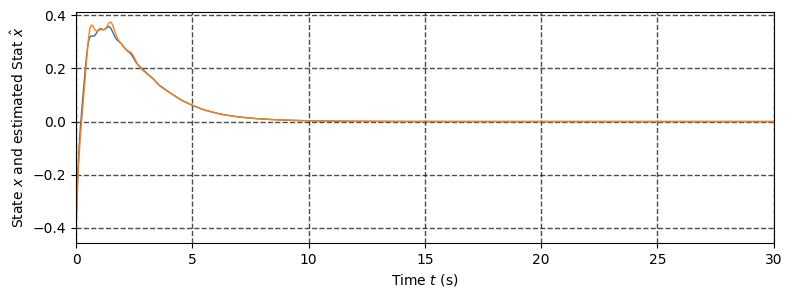

In [560]:
figure(figsize=(9, 3))

# plot(t, state_sol_dist, linewidth=1.0)
plot(t, state_sol[:,0], linewidth=1.0)
plot(t, state_sol[:,n], linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'State ${x}$ and estimated Stat $\hat{x}$')
xlabel(r'Time $t$ (s)')
show()


In [561]:
error=state_sol[:,:n]-state_sol[:,n:]
print(error.shape)

(200000, 14)


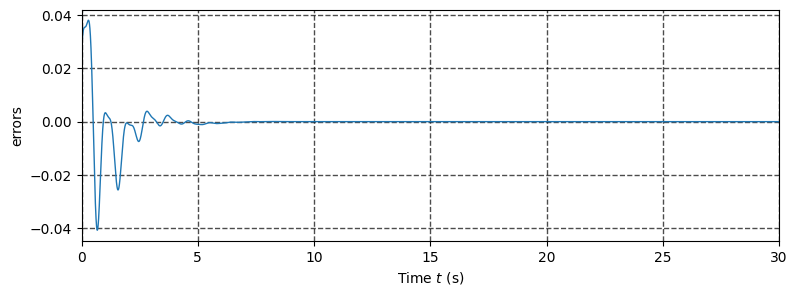

In [562]:
figure(figsize=(9, 3))
plot(t,error[:,0], linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'errors')
xlabel(r'Time $t$ (s)')
show()


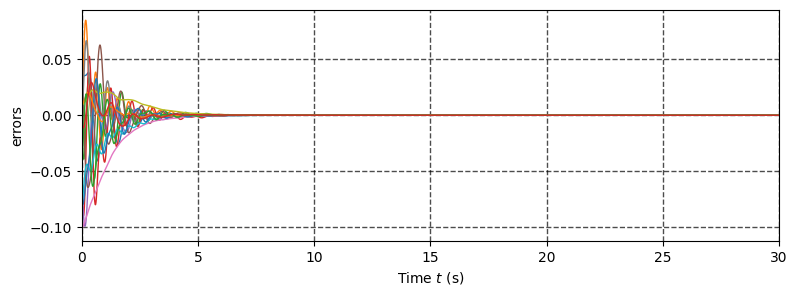

In [563]:
figure(figsize=(9, 3))
plot(t,error, linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'errors')
xlabel(r'Time $t$ (s)')
show()


### Simulate LMI with input distrbance

In [564]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import place_poles
from matplotlib.pyplot import *
from scipy.integrate import odeint



def sys_ode_distrubance(state, t):

    # w=1*np.array([np.sin(t),np.sin(t),np.sin(t),np.sin(t)])
    # w=np.array([1,1])
    if t<10:
      w=np.array([1,1,1,1])
    else:
      w=np.array([0,0,0,0])

    x= state[0:n]
    r=x[0:dof_z]
    q=x[dof_z:]
    x_hat=state[n:]


    A_o=np.vstack((np.hstack((An,Ar)),np.zeros((dof_zeta,n))))

    B_o=np.vstack((B,np.zeros((dof_zeta,m))))

    u=K@x_hat

    y_hat=C@E@x_hat

    y=C@E@x+D2@w


    dx_hat=A_o@x_hat+B_o@u+L@(y-y_hat)


    e=x-x_hat

    dr=An@r+B@K_r@r-B@K@e+N.T@D1c@w

    dx = np.hstack((dr, [0,0,0,0,0,0,0,0]))

    dstate = np.hstack((dx, dx_hat))
    return dstate


In [565]:
T = 30# Final time

t = np.linspace(0, T, int(2E5)) # Create time span

state_0 = np.hstack((x_real_0, x_hat_0))

state_sol_dist = odeint(sys_ode_distrubance, state_0, t)

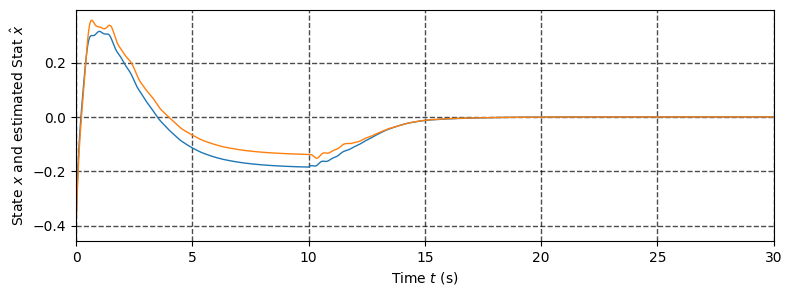

In [566]:
figure(figsize=(9, 3))

# plot(t, state_sol_dist, linewidth=1.0)
plot(t, state_sol_dist[:,0], linewidth=1.0)
plot(t, state_sol_dist[:,n], linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'State ${x}$ and estimated Stat $\hat{x}$')
xlabel(r'Time $t$ (s)')
show()


In [567]:
error_dist=state_sol_dist[:,:n]-state_sol_dist[:,n:]
print(error_dist.shape)

(200000, 14)


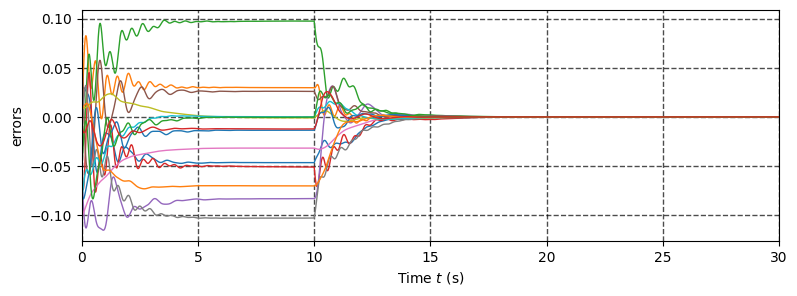

In [568]:
figure(figsize=(9, 3))
plot(t,error_dist, linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'errors')
xlabel(r'Time $t$ (s)')
show()




---



# $H_{∞}$

### Search for best epsilon to solve the LMI

In [569]:



gammas=[]
min_gamma=10000

epsilon_plot=[]



j=0
limit=10**-10
lower=limit
upper=1
kaps=np.linspace(0.000001, 1-0.000001,1000)
# for epsilon in epsilons:
for kap in  kaps:

  P1 = cp.Variable((dof_z,dof_z),symmetric=True)
  Q2 = cp.Variable((n,n),symmetric=True)

  U = cp.Variable((m,dof_z))
  # V = cp.Variable((14,14))
  # V = cp.Variable((14,8))
  V = cp.Variable((n,l))

  epsilon=kap/(1-kap)

  gamma=cp.Variable()

  obj = cp.Minimize(gamma)
  constraints = []

  Psi1=P1@A1.T+A1@P1+B@U+U.T@B.T
  Psi2=A2.T@Q2+Q2@A2-V@C@E-E.T@C.T@V.T



  H=cp.vstack((cp.hstack((P1,np.zeros((dof_z,dof_zeta)))),cp.hstack((np.zeros((dof_zeta,dof_z)),np.eye(dof_zeta)))))


  Term1=cp.hstack((B@U,B@K_q))




  LMI= cp.bmat([[Psi1,np.zeros((dof_z,n)),S.T@Dn,P1@C1.T,Term1,np.zeros((dof_z,n))],
    [np.zeros((n,dof_z)),Psi2,Q2@Dn-V@D2,C2.T,np.zeros((n,n)),np.eye(n)],
    [Dn.T@S,Dn.T@Q2-D2.T@V.T,-gamma*np.eye(m),D3.T,np.zeros((m,n)),np.zeros((m,n))],
    [C1@P1,C2,D3,-gamma*np.eye(dof_z),np.zeros((dof_z,n)),np.zeros((dof_z,n))],
    [Term1.T,np.zeros((n,n)),np.zeros((n,m)),np.zeros((n,dof_z)),-(1/epsilon)*H,np.zeros((n,n))],
    [np.zeros((n,dof_z)),np.eye(n),np.zeros((n,m)),np.zeros((n,dof_z)),np.zeros((n,n)),-epsilon*H]])

  constraints.extend([P1>>0])
  constraints.extend([Q2>>0])
  constraints.extend([LMI<<0])
  constraints.extend([gamma>=0])




  prob = cp.Problem(obj, constraints)

  # result = prob.solve(solver=cp.MOSEK,verbose=True)
  # result = prob.solve(solver=cp.MOSEK)
  try:
        result = prob.solve(solver=cp.MOSEK)
        # break
  except:
        print("Oops!  That was no valid number.  Try again...")
        # break;

      # print(j)
  if gamma.value!=None:
    print("gamma: ", gamma.value)
    print("epsilon: ", epsilon)
    if min_gamma>=gamma.value:
      min_gamma=gamma.value
      target_epsilon=epsilon
    gammas.append(gamma.value)
    epsilon_plot.append(epsilon)
    # e_p, _ = np.linalg.eig(P1.value)
    # e_q, _ = np.linalg.eig(Q2.value)


    # print("eig of P1: ",e_p)
    # print("eig of Q2: ",e_q)

    K_r=U.value@pinv(P1.value,rcond=10**-9)
    L=pinv(Q2.value,rcond=10**-9)@V.value

    print("K_r: ",K_r)
    print("L: ",L)
  if epsilon>1:
    break;


gamma:  3185.6888010003486
epsilon:  1.000001000001e-06
K_r:  [[  440158.51438113   114049.00938006   549906.95124208  -827249.7848938
    -73442.73355016  -594137.20683119]
 [ -233109.02426256  -420677.10077732 -1178975.7301567     77131.13621546
   -428116.46813715   463220.38141641]
 [  299654.16172825   -64596.98996529   110331.76973088  -679656.52557636
   -270364.26933356  -366765.43771344]
 [ -146699.00207152  -111787.12458266  -409162.85443692   255646.52715112
    -74985.17830044   216664.97758466]]
L:  [[-2.28761794e+00  4.57830019e+00 -1.61658706e+01 -1.44147079e+00
  -1.03479259e+01 -1.92511697e+01  9.67012078e-01  5.19314284e+00
   1.03625917e+01  1.20056880e+01]
 [-3.43002732e+00  2.01086055e+00  3.71262774e-01  8.23806655e-01
  -7.08944613e+00 -3.08274250e+00 -2.65147042e+00  7.99378982e+00
   1.40129097e+01  2.79329660e+00]
 [ 3.19156441e+01 -1.01256122e+01  5.10497698e+01  7.68773653e+00
   2.94185064e+01  4.08830949e+01 -1.98825903e+01 -4.53135741e+00
  -5.12767597e+0

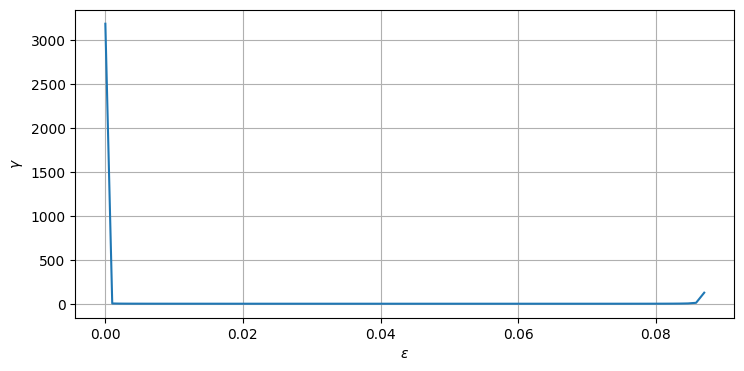

min_gamma:  0.06245988188989365
target_epsilon:  0.06845019317659706


In [570]:
from matplotlib.pyplot import *

figure(figsize=(8.5, 4.))
plot(epsilon_plot,gammas)
xlabel(r'$\epsilon$')
ylabel(r'$\gamma$')
grid()
show()

print("min_gamma: ",min_gamma)
print("target_epsilon: ",target_epsilon)



### Best epsilon controller

In [571]:
# Import time module
import time

# record start time
start = time.time()

n=14
m=4

I=np.eye(n)

epsilon=target_epsilon



P1 = cp.Variable((dof_z,dof_z),symmetric=True)
Q2 = cp.Variable((n,n),symmetric=True)

U = cp.Variable((m,dof_z))
V = cp.Variable((n,l))



gamma=cp.Variable()

obj = cp.Minimize(gamma)
constraints = []

Psi1=P1@A1.T+A1@P1+B@U+U.T@B.T
Psi2=A2.T@Q2+Q2@A2-V@C@E-E.T@C.T@V.T



H=cp.vstack((cp.hstack((P1,np.zeros((dof_z,dof_zeta)))),cp.hstack((np.zeros((dof_zeta,dof_z)),np.eye(dof_zeta)))))


Term1=cp.hstack((B@U,B@K_q))


LMI= cp.bmat([[Psi1,np.zeros((dof_z,n)),S.T@Dn,P1@C1.T,Term1,np.zeros((dof_z,n))],
[np.zeros((n,dof_z)),Psi2,Q2@Dn-V@D2,C2.T,np.zeros((n,n)),np.eye(n)],
[Dn.T@S,Dn.T@Q2-D2.T@V.T,-gamma*np.eye(m),D3.T,np.zeros((m,n)),np.zeros((m,n))],
[C1@P1,C2,D3,-gamma*np.eye(dof_z),np.zeros((dof_z,n)),np.zeros((dof_z,n))],
[Term1.T,np.zeros((n,n)),np.zeros((n,m)),np.zeros((n,dof_z)),-(1/epsilon)*H,np.zeros((n,n))],
[np.zeros((n,dof_z)),np.eye(n),np.zeros((n,m)),np.zeros((n,dof_z)),np.zeros((n,n)),-epsilon*H]])



constraints.extend([P1>>0])
constraints.extend([Q2>>0])
constraints.extend([LMI<<0])
constraints.extend([gamma>=0])


prob = cp.Problem(obj, constraints)

result = prob.solve(solver=cp.MOSEK,verbose=True)


# record end time
end = time.time()

# print the difference between start
# and end time in milli. secs
print()

print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")
print()
print("gamma: ", gamma.value)


e_p, _ = np.linalg.eig(P1.value)
e_q, _ = np.linalg.eig(Q2.value)


print("eig of P1: ",e_p)
print("eig of Q2: ",e_q)


K_r=U.value@pinv(P1.value)
L=pinv(Q2.value)@V.value

print("K_r: ",K_r)
print("L: ",L)



                                     CVXPY                                     
                                     v1.3.3                                    
(CVXPY) Feb 14 11:48:58 AM: Your problem has 397 variables, 4 constraints, and 0 parameters.
(CVXPY) Feb 14 11:48:58 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 14 11:48:58 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 14 11:48:58 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 14 11:48:58 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 14 11:48:58 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

In [572]:
## Check closed loop stability
K=np.hstack((K_r,K_q))
A_close=np.vstack((np.hstack((A1+B@K_r,-B@K)),np.hstack((np.zeros((14,6)),A2-L@C@E))))

e, _ = np.linalg.eig(A_close)
print("eigenvalues of the closed loop system: ",e)

print("max eigenvalue: ",max(e.real))

eigenvalues of the closed loop system:  [-11.22015475 +0.j         -10.31522031 +0.j
  -6.28656534 +0.j          -2.05307097 +0.j
  -0.98527169 +0.j          -1.59401647 +0.j
  -1.37355449+14.16163293j  -1.37355449-14.16163293j
  -1.53428325+10.27747335j  -1.53428325-10.27747335j
  -1.2782637  +6.26114788j  -1.2782637  -6.26114788j
  -4.18662218 +0.j          -1.27085238 +3.4750173j
  -1.27085238 -3.4750173j   -1.52615328 +1.63388804j
  -1.52615328 -1.63388804j  -1.2132527  +0.j
  -0.46946966 +0.j          -0.12688963 +0.j        ]
max eigenvalue:  -0.1268896266960565


### Simlulate $H_{∞}$ without input distrbance

In [573]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import place_poles
from matplotlib.pyplot import *
from scipy.integrate import odeint

def sys_ode(state, t):

    x= state[0:n]
    r=x[0:dof_z]
    q=x[dof_z:]
    x_hat=state[n:]


    A_o=np.vstack((np.hstack((An,Ar)),np.zeros((dof_zeta,n))))

    B_o=np.vstack((B,np.zeros((dof_zeta,m))))

    u=K@x_hat

    y_hat=C@E@x_hat

    y=C@E@x


    dx_hat=A_o@x_hat+B_o@u+L@(y-y_hat)


    e=x-x_hat

    dr=An@r+B@K_r@r-B@K@e

    dx = np.hstack((dr, [0,0,0,0,0,0,0,0]))

    dstate = np.hstack((dx, dx_hat))
    return dstate


In [574]:
T = 30# Final time

t = np.linspace(0, T, int(2E5)) # Create time span

# x_real_0 = [0.2,0.1,0.1,0,0,1] # Set initial state
# x_hat_0 =  [0.21,0.11,0,0,0,1.2]

state_0 = np.hstack((x_real_0, x_hat_0))

state_sol = odeint(sys_ode, state_0, t)

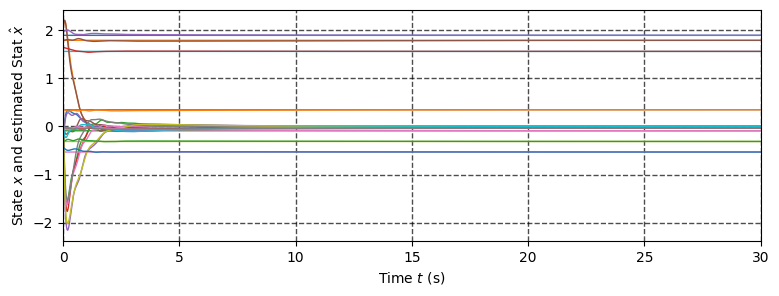

In [575]:
figure(figsize=(9, 3))

plot(t, state_sol, linewidth=1.0)
# plot(t, state_sol[:,n], linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'State ${x}$ and estimated Stat $\hat{x}$')
xlabel(r'Time $t$ (s)')
show()


In [576]:
error=state_sol[:,:n]-state_sol[:,n:]
print(error.shape)

(200000, 14)


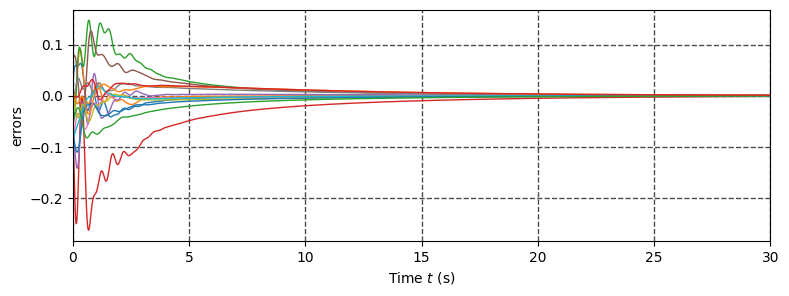

In [577]:
figure(figsize=(9, 3))
plot(t,error, linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'errors')
xlabel(r'Time $t$ (s)')
show()


### Simlulate $H_{∞}$ with input distrbance

In [578]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import place_poles
from matplotlib.pyplot import *
from scipy.integrate import odeint



def sys_ode_distrubance(state, t):

    # w=1*np.array([np.sin(t),np.sin(t),np.sin(t),np.sin(t)])
    # w=np.array([1,1])
    if t<10:
      w=np.array([1,1,1,1])
    else:
      w=np.array([0,0,0,0])

    x= state[0:n]
    r=x[0:dof_z]
    q=x[dof_z:]
    x_hat=state[n:]


    A_o=np.vstack((np.hstack((An,Ar)),np.zeros((dof_zeta,n))))

    B_o=np.vstack((B,np.zeros((dof_zeta,m))))

    u=K@x_hat

    y_hat=C@E@x_hat

    y=C@E@x+D2@w


    dx_hat=A_o@x_hat+B_o@u+L@(y-y_hat)


    e=x-x_hat

    dr=An@r+B@K_r@r-B@K@e+N.T@D1c@w

    dx = np.hstack((dr, [0,0,0,0,0,0,0,0]))

    dstate = np.hstack((dx, dx_hat))
    return dstate


In [579]:
T = 30# Final time

t = np.linspace(0, T, int(2E5)) # Create time span

state_0 = np.hstack((x_real_0, x_hat_0))

state_sol_dist = odeint(sys_ode_distrubance, state_0, t)

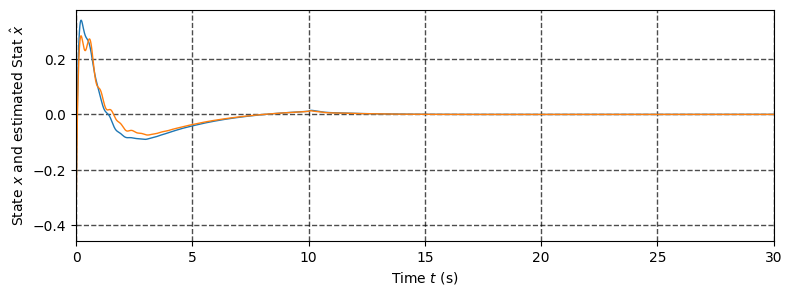

In [580]:
figure(figsize=(9, 3))

# plot(t, state_sol_dist, linewidth=1.0)
plot(t, state_sol_dist[:,0], linewidth=1.0)
plot(t, state_sol_dist[:,n], linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'State ${x}$ and estimated Stat $\hat{x}$')
xlabel(r'Time $t$ (s)')
show()


In [581]:
error_dist=state_sol_dist[:,:n]-state_sol_dist[:,n:]
print(error_dist.shape)

(200000, 14)


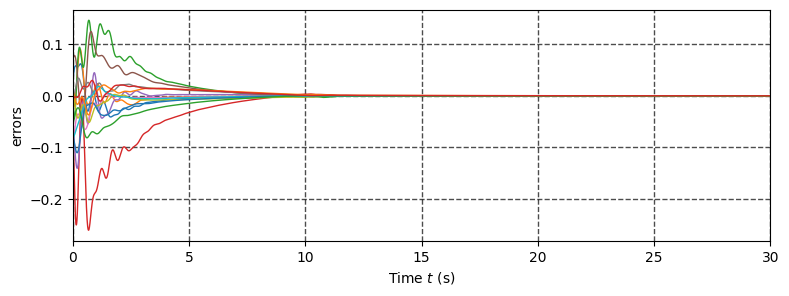

In [582]:
figure(figsize=(9, 3))
plot(t,error_dist, linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'errors')
xlabel(r'Time $t$ (s)')
show()


In [583]:
z=[]

for i in range(len(state_sol_dist)):

  dt=T/int(2E5)
  # w=np.array([[np.sin(2*i*dt)]])
  # w=np.array([np.sin(i*dt),np.sin(i*dt)])
  w=np.array([1,1])
  res=C1@state_sol_dist[i,0:dof_z]+C2@error[i]#+D3@w
  # print(res)
  z.append(res)
z=np.array(z)

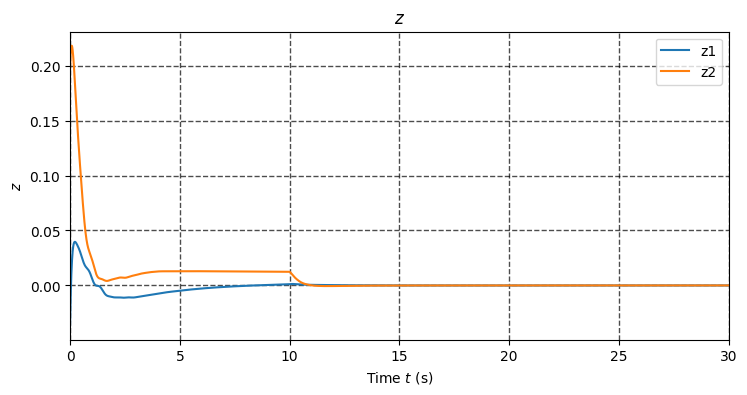

In [600]:
# plot theta1 and theta2
from matplotlib.pyplot import *

z1, z2 ,z3, z4  = z[:,0], z[:,1], z[:,2], z[:,3]

figure(figsize=(8.5, 4.))
title(r'$z$')
# plot(t,0.01*np.sin(t),label='W')
plot(t,z1,label='z1')
plot(t,z2,label='z2')
# plot(t,z3,label='z3')
# plot(t,z4,label='z4')

legend()
xlim([0, T])
# ylim([-0.5, 0.5])

grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
ylabel(r'$z$')
xlabel(r'Time $t$ (s)')

show()





---



# Numerical computation of $L_2$ norm for the output signal $z(t)$

In [585]:
input=[]
T=30
N1=int(2E5)
for i in range(N1):
  dt=T/N1
  if (i*dt<10):
      w=np.array([1,1,1,1])
  else:
      w=np.array([0,0,0,0])
  input.append(w)
input=np.array(input)

In [608]:
Total_input=(input[:,0]*input[:,0]+input[:,1]*input[:,1]+input[:,2]*input[:,2]+input[:,3]*input[:,3])

from scipy import integrate
I1 = integrate.simpson(Total_input, t)
# print(I1)
# print(np.sqrt(I1))
L2_Input=np.sqrt(I1)
print("L2_Input: ",L2_Input)

L2_Input:  6.324555320336758


In [609]:
Total_z=(z[:,0]*z[:,0]+z[:,1]*z[:,1])

from scipy import integrate
I1 = integrate.simpson(Total_z, t)
# print(I1)
# print(np.sqrt(I1))
L2_Z=np.sqrt(I1)
print("L2_Z: ",L2_Z)

L2_Z:  0.13705850093326924


In [610]:
L2_Gain_numerical=L2_Z/L2_Input
print("L2 Gain numerical:\n",L2_Gain_numerical)

L2 Gain numerical:
 0.021670851781872218




---



# Analytical computation of $L_2$ norm for the output signal $z(t)$

In [589]:
e0=x_real_0-x_hat_0
# print(e0)
x_0=np.hstack((x_real_0[:dof_z],e0))
# print(x_0)

In [590]:
dt=T/N1
state_sol_dist[int(10/dt),:]

r_T=state_sol_dist[int(10/dt),:]
x_T=np.hstack((r_T[:dof_z],error_dist[int(10/dt),:]))
# print(x_T)

In [591]:
TT=10
Aa=A_close
Bb=np.vstack((S.T@Dn,Dn-L@D2))
Cc=np.hstack((C1,C2))

w0=np.array([1,1,1,1])
x0=x_0
xT=x_T

In [592]:
mm=x_0+pinv(Aa)@Bb@w0
nn=pinv(Aa)@Bb@w0

In [593]:
Q = cp.Variable((20,20),symmetric=True)
obj = cp.Minimize(0)
constraints = []

constraints.extend([Aa.T@Q+Q@Aa==-Cc.T@Cc])

prob = cp.Problem(obj, constraints)
result = prob.solve(solver=cp.MOSEK)
# print(Q.value)

result0=xT.T@(Q.value)@xT
print(result0)

0.00019901996101636256


In [594]:
import scipy.integrate as integrate
import scipy.special as special


result1 = integrate.quad(lambda x: mm.T@scipy.linalg.expm(Aa.T*x)@Cc.T@Cc@scipy.linalg.expm(Aa*x)@mm, 0, TT)
result1

(0.0573522432852277, 4.561689473874404e-09)

In [595]:
import scipy.integrate as integrate
import scipy.special as special


result2 = integrate.quad(lambda x: -mm.T@scipy.linalg.expm(Aa.T*x)@Cc.T@Cc@nn, 0, TT)
result2

(0.0038815097013755314, 8.753552820610274e-09)

In [596]:
import scipy.integrate as integrate
import scipy.special as special


result3 = integrate.quad(lambda x: -nn.T@Cc.T@Cc@scipy.linalg.expm(Aa*x)@mm, 0, TT)
result3

(0.003881509701375529, 8.753552823378165e-09)

In [597]:
result4=nn.T@Cc.T@Cc@nn*TT
result4

0.006812559833560274

In [604]:
result=result0+result1+result2+result3+result4
anlytical_norm=np.sqrt(result[0])
print("L2 norm of the output z:\n",anlytical_norm)

L2 norm of the output z:
 0.26856441030515454


In [612]:
L_2_Gain_anlytical=anlytical_norm/L2_Input
print("L2 gain anlytical:\n",L_2_Gain_anlytical)

L2 gain anlytical:
 0.04246376175121424




---

